# Worked out example with L1 regularization

Example of walk-through using dataframce and scikit-learn pipelines 

In [4]:
import numpy as np
import pandas as pd

# Get data
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# Rename columns
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
# Split data
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [6]:
# Scale features
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [11]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [13]:
# biases
lr.intercept_

array([-1.26331132, -1.2158668 , -2.37043291])

In [14]:
# weights
lr.coef_

array([[ 1.24564024,  0.18060685,  0.74353558, -1.16107281,  0.        ,
         0.        ,  1.17077021,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54671113,  2.51061728],
       [-1.53675733, -0.38717744, -0.99493902,  0.36484286, -0.05959526,
         0.        ,  0.66838653,  0.        ,  0.        , -1.93427504,
         1.23353683,  0.        , -2.23196494],
       [ 0.13583962,  0.1684487 ,  0.35722267,  0.        ,  0.        ,
         0.        , -2.43852982,  0.        ,  0.        ,  1.56364736,
        -0.8188113 , -0.49231583,  0.        ]])

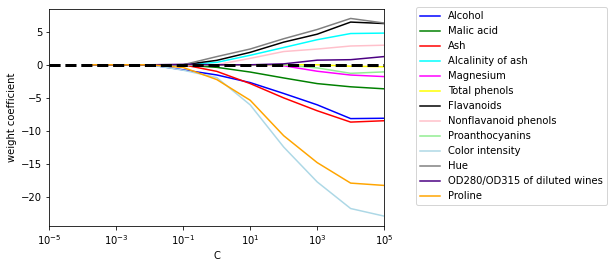

In [16]:
# impact of C
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

### L2 regularization

$
L2: ||w||_2^2 = \sum_{j=1}^m w_j^{2}
$

The strenght of the L2 regularization $\lambda$ controls the weights of the learning algorithm. By increasing the regularization strenght, we shrink the weights towards zero since the gradient is higher, i.e. get quicker to the minimum.

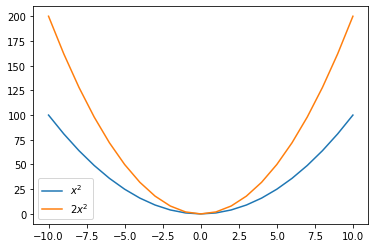

In [27]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(-10,11,1)
plt.plot(x, x**2, label='$x^2$')
plt.plot(x, 2*x**2, label='2$x^2$')
plt.legend()
plt.draw()

# Sequential Backward Selection (SBS)

In [51]:
from sklearn.base import clone # Clone does a deep copy of the model in an estimator without actually copying attached data. It yields a new estimator with the same parameters that has not been fitted on any data.
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS(object):
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.estimator = clone(estimator) 
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
        
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

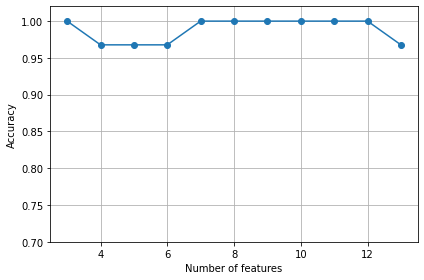

In [63]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=3)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [64]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 11),
 (0, 1, 2, 3, 4, 5, 7, 9, 11),
 (0, 1, 2, 3, 5, 7, 9, 11),
 (0, 1, 2, 3, 5, 7, 11),
 (0, 1, 2, 3, 5, 11),
 (0, 1, 2, 3, 11),
 (0, 1, 2, 11),
 (0, 1, 11)]

In [65]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [66]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [67]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


In [68]:
sbs.transform(X_train_std).shape

(124, 3)

In [69]:
sbs.transform(X_train_std)[:5]

array([[ 0.71225893,  2.22048673, -0.82164144],
       [ 0.88229214, -0.70457155,  0.54931269],
       [ 0.84585645, -0.73022996,  0.1308109 ],
       [ 0.57866141, -0.4736459 ,  0.36170844],
       [-0.52655446,  0.09083903, -1.49990297]])

In [70]:
X_train_std[:5]

array([[ 0.71225893,  2.22048673, -0.13025864,  0.05962872, -0.50432733,
        -0.52831584, -1.24000033,  0.84118003, -1.05215112, -0.29218864,
        -0.20017028, -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, -0.09065504,  2.34147876,
         1.01675879,  0.66299475,  1.0887425 , -0.49293533,  0.13152077,
         1.33982592,  0.54931269,  1.47568796],
       [ 0.84585645, -0.73022996,  1.17533605,  0.81104754,  0.13597904,
         1.09807851,  1.16326665, -0.64419483,  1.25249578,  0.25863359,
         1.06806189,  0.1308109 ,  1.62934866],
       [ 0.57866141, -0.4736459 ,  0.98882252, -0.24093881,  0.77628541,
         0.04092218,  0.45700044, -0.64419483, -0.1709626 , -0.37693052,
         0.66041583,  0.36170844,  1.045438  ],
       [-0.52655446,  0.09083903, -0.68979922, -0.39122257, -0.36203702,
        -1.1463457 , -1.37732987,  2.16151323, -1.18771859,  0.85182676,
        -1.01546239, -1.49990297, -0.18384759]])